# Testing reported Covid-19 deaths and cases for Poisson underdispersion

In [1]:
%matplotlib notebook

import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns
import matplotlib
import pickle

In [2]:
# Get a given percentile of the distribution of sample variances of Poisson
# distibution with a given mean (via sampling)

def poissonsamplevar(mu, n, perc=5, nrep=1000, seed=42):
    np.random.seed(seed)
    
    v = np.zeros(nrep)
    for i in range(nrep):
        x = np.random.poisson(mu, size=n)
        v[i] = np.var(x, ddof=1)
    return np.percentile(v, perc)

In [3]:
# Chop a time series into non-overlapping windows and test each window
# for underdispersion. Returns the test result, and also the mean/variance
# ratio

def chop_and_test(x, window=7, nrep=1000, perc=5, seed=42):
    length = np.floor(x.size/window).astype(int)
    testresult = np.zeros(length)
    ratio = np.zeros(length)
    
    for i in range(length):
        tt = x[i*window:(i+1)*window].copy()
        tt[tt<0] = 0
        if np.var(tt, ddof=1) < poissonsamplevar(np.mean(tt), window, 
                                         nrep=nrep, perc=perc, seed=seed):
            testresult[i] = 1
            
        if np.mean(tt) > 0:
            ratio[i] = np.mean(tt) / (np.var(tt, ddof=1) + .1)
        else:
            ratio[i] = 1
            
    return testresult, ratio

In [4]:
# Criterion we use to declare that a country shows significant underdispersion

def criterion(test_results, cutoff=15, chunkcutoff=4):
    max_consecutive_length = len(max("".join(map(str, test_results.astype('int'))).split("0")))
    flag = np.sum(test_results) >= cutoff or max_consecutive_length >= chunkcutoff
    return flag

In [5]:
# Load WHO data

# df = pd.read_csv('https://covid19.who.int/WHO-COVID-19-global-data.csv')
df = pd.read_csv('frozen-data/WHO-COVID-19-global-data.csv')

countries = np.unique(df['Country'])
print(f'{countries.size} countries in the WHO dataset')

237 countries in the WHO dataset


In [6]:
# Shortening some country names

renames = {'Republic of Moldova': 'Moldova',
           'Russian Federation': 'Russia',
           'Syrian Arab Republic': 'Syria',
           'United Arab Emirates': 'UAE',
           'Venezuela (Bolivarian Republic of)': 'Venezuela'}

## Some useful simulations

....

<IPython.core.display.Javascript object>


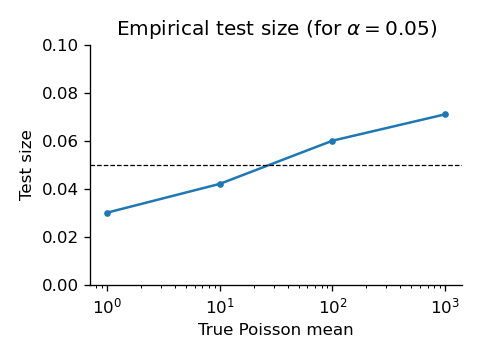

CPU times: user 1min 52s, sys: 180 ms, total: 1min 52s
Wall time: 1min 52s


In [7]:
%%time

# Check the test size for alpha=0.05. 
# Conclusion: reasonably close to 0.05.

test_size_nweeks = 1000

means = [1,10,100,1000]
sizes = []
for m in means:
    print('.', end='')
    np.random.seed(1)
    x = np.random.poisson(m, size=7 * test_size_nweeks)
    size = np.mean(chop_and_test(x)[0])
    sizes.append(size)
    
plt.figure(figsize=(4,3))
plt.plot(means,sizes,'.-')
plt.xlabel('True Poisson mean')
plt.ylabel('Test size')
plt.title(r'Empirical test size (for $\alpha=0.05$)')
plt.xscale('log')
xl = plt.xlim()
plt.plot(xl,[.05,.05],'k--',lw=.75)
plt.xlim(xl)
plt.ylim([0,.1])

sns.despine()
plt.tight_layout()
plt.savefig('test-size.png')

<IPython.core.display.Javascript object>


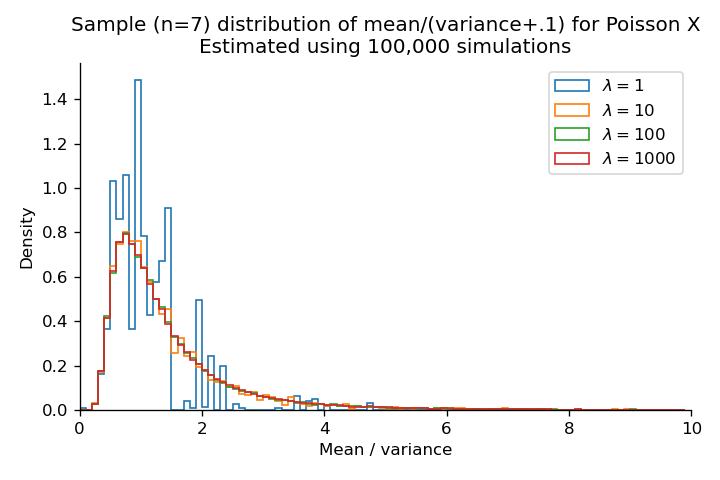

CPU times: user 17.8 s, sys: 72.1 ms, total: 17.9 s
Wall time: 17.8 s


In [8]:
%%time

# Simulation: sample 1/FF for Poisson

np.random.seed(42)
nrep = 100_000
    
plt.figure(figsize=(6,4))

for mu in [1, 10, 100, 1000]:
    v = np.zeros(nrep)
    for i in range(nrep):
        x = np.random.poisson(mu, size=7)
        v[i] = np.mean(x)/(np.var(x, ddof=1) + .1)
    plt.hist(v, density=True, bins=np.arange(0,10,.1), label=f'$\lambda={mu}$', histtype='step')

plt.xlabel('Mean / variance')
plt.ylabel('Density')
plt.title('Sample (n=7) distribution of mean/(variance+.1) for Poisson X\nEstimated using 100,000 simulations')
plt.xlim([0,10])
plt.legend()

sns.despine()
plt.tight_layout()
plt.savefig('ratios.png', dpi=100)

## Illustration

In [9]:
# Number of simulations used in the illustration figure
# Recommend 1e6, but it takes a while to compute

nrep = 1_000_000

<IPython.core.display.Javascript object>


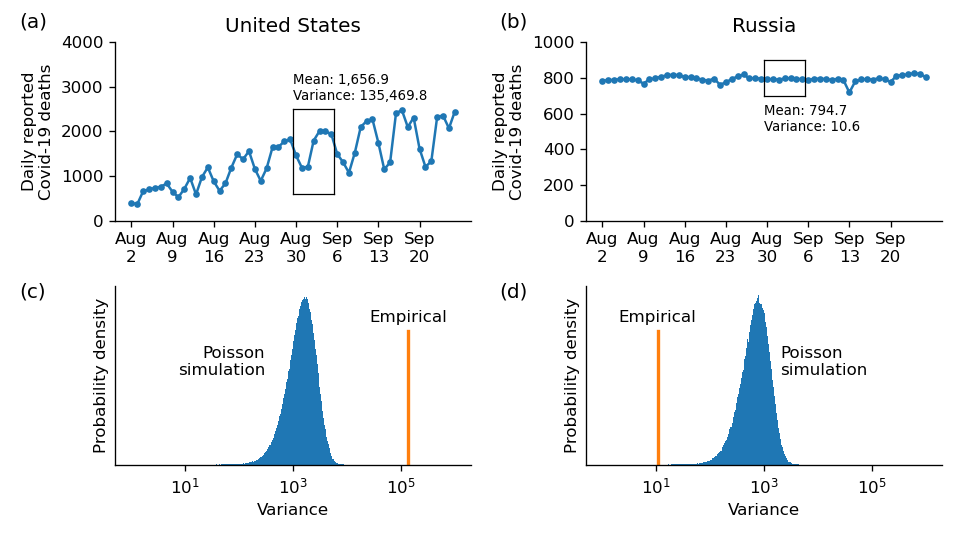

In [10]:
country = 'Russian Federation'

dates = df[df['Country']==country]['Date_reported'].values
ind = [(s>='2020-03-02') & (s<='2021-09-26') for s in dates]
deaths = df[df['Country']==country]['New_deaths'].values[ind]
cases  = df[df['Country']==country]['New_cases' ].values[ind]    
x = deaths[-56:]

fig = plt.figure(figsize=(8,4.5))

plt.subplot(222)
plt.plot(x, '.-')
plt.ylim([0,1000])
plt.title('Russia')
plt.ylabel('Daily reported\nCovid-19 deaths')

plt.xticks(np.arange(0,50,7), 
           ['Aug\n2', 'Aug\n9', 'Aug\n16', 'Aug\n23', 'Aug\n30', 'Sep\n6', 'Sep\n13', 'Sep\n20'])

plt.plot([27.5,34.5], [700,700], 'k', linewidth=.75)
plt.plot([27.5,34.5], [900,900], 'k', linewidth=.75)
plt.plot([27.5,27.5], [700,900], 'k', linewidth=.75)
plt.plot([34.5,34.5], [700,900], 'k', linewidth=.75)

x = x[28:35]
plt.text(27.5, 500, f'Mean: {np.mean(x):.1f}\nVariance: {np.var(x, ddof=1):.1f}', fontsize=8);

In [11]:
print('Data:     ', x)
print('Mean:     ', np.mean(x))
print('Variance: ', np.var(x, ddof=1))
print('Std:      ', np.std(x, ddof=1))

v = np.zeros(nrep)
np.random.seed(42)
for i in range(nrep):
    if (i+1) % 100_000 == 0:
        print('.', end='')
    v[i] = np.var(np.random.poisson(np.mean(x), size=x.size), ddof=1)
print('')
    
print('Mean of simulated variances: ', np.mean(v))
print('Number below empirical:      ', np.sum(v <= np.var(x, ddof=1)))
print('Fraction below empirical:    ', np.mean(v <= np.var(x, ddof=1)))

plt.subplot(224)
logbins = np.logspace(np.log10(1),np.log10(1_000_000), 1000)
plt.hist(v, bins=logbins)
plt.xscale('log')
plt.xlabel('Variance')
plt.yticks([])
plt.ylabel('Probability density');

yl = plt.ylim()
plt.plot([np.var(x, ddof=1), np.var(x, ddof=1)], [yl[0], yl[1]*.75], linewidth=2)
plt.ylim(yl)

plt.text(2000, yl[1]/2, 'Poisson\nsimulation', fontsize=10)
plt.text(np.var(x, ddof=1), yl[1]*.8, 'Empirical', fontsize=10, ha='center');

Data:      [792 795 790 798 799 796 793]
Mean:      794.7142857142857
Variance:  10.571428571428571
Std:       3.251373336211726
..........
Mean of simulated variances:  794.4447129523809
Number below empirical:       7
Fraction below empirical:     7e-06


In [12]:
country = 'United States of America'

dates = df[df['Country']==country]['Date_reported'].values
ind = [(s>='2020-03-02') & (s<='2021-09-26') for s in dates]
deaths = df[df['Country']==country]['New_deaths'].values[ind]
cases  = df[df['Country']==country]['New_cases' ].values[ind]    
x = deaths[-56:]

plt.subplot(221)
plt.plot(x, '.-')
plt.ylim([0,4000])
plt.title('United States')
plt.ylabel('Daily reported\nCovid-19 deaths')

plt.xticks(np.arange(0,50,7), 
           ['Aug\n2', 'Aug\n9', 'Aug\n16', 'Aug\n23', 'Aug\n30', 'Sep\n6', 'Sep\n13', 'Sep\n20'])

plt.plot([27.5,34.5], [600,600], 'k', linewidth=.75)
plt.plot([27.5,34.5], [2500,2500], 'k', linewidth=.75)
plt.plot([27.5,27.5], [600,2500], 'k', linewidth=.75)
plt.plot([34.5,34.5], [600,2500], 'k', linewidth=.75)

x = x[28:35]
plt.text(27.5, 2700, f'Mean: {np.mean(x):,.1f}\nVariance: {np.var(x, ddof=1):,.1f}', fontsize=8);

In [13]:
print('Data:     ', x)
print('Mean:     ', np.mean(x))
print('Variance: ', np.var(x, ddof=1))
print('Std:      ', np.std(x, ddof=1))

v = np.zeros(nrep)
np.random.seed(42)
for i in range(nrep):
    if (i+1) % 100_000 == 0:
        print('.', end='')
    v[i] = np.var(np.random.poisson(np.mean(x), size=x.size), ddof=1)
print('')
    
print('Mean of simulated variances: ', np.mean(v))
print('Number below empirical:      ', np.sum(v <= np.var(x, ddof=1)))
print('Fraction below empirical:    ', np.mean(v <= np.var(x, ddof=1)))

plt.subplot(223)
logbins = np.logspace(np.log10(1),np.log10(1_000_000), 1000)
plt.hist(v, bins=logbins)
plt.xscale('log')
plt.xlabel('Variance')
plt.yticks([])
plt.ylabel('Probability density')

yl = plt.ylim()
plt.plot([np.var(x, ddof=1), np.var(x, ddof=1)], [yl[0], yl[1]*.75], linewidth=2)
plt.ylim(yl)

plt.text(300, yl[1]/2, 'Poisson\nsimulation', fontsize=10, ha='right')
plt.text(np.var(x, ddof=1), yl[1]*.8, 'Empirical', fontsize=10, ha='center');

Data:      [1461 1185 1202 1795 2010 2003 1942]
Mean:      1656.857142857143
Variance:  135469.80952380953
Std:       368.062235938176
..........
Mean of simulated variances:  1656.5717089999998
Number below empirical:       1000000
Fraction below empirical:     1.0


In [14]:
sns.despine()
plt.tight_layout()

fig.text(.02, .95, '(a)', fontsize=12)
fig.text(.52, .95, '(b)', fontsize=12)
fig.text(.02, .45, '(c)', fontsize=12)
fig.text(.52, .45, '(d)', fontsize=12)

plt.savefig('img/illustration.png', dpi=200)
plt.savefig('img/illustration.pdf')

## Screening all countries for underdispersion

In [15]:
enddate = '2022-01-30'

# Check that all countries have the info already

for c in np.unique(df['Country']):
    dates = df[df['Country']==c]['Date_reported'].values
    if np.sum(dates == enddate) == 0:
        print(c)
        
# How many weeks

dates = df[df['Country']=='France']['Date_reported'].values
ind = [(s>='2020-03-02') & (s<=enddate) for s in dates]
print(np.sum(ind))
print(np.sum(ind)/7)
print(np.sum(ind)/7/10)

nweeks = int(np.sum(ind)/7)

700
100.0
10.0


In [16]:
%%time

deaths_tests = np.zeros((countries.size, nweeks))
deaths_ratios = np.zeros((countries.size, nweeks))

cases_tests = np.zeros((countries.size, nweeks))
cases_ratios = np.zeros((countries.size, nweeks))

deaths_tests_weekly = np.zeros((countries.size, int(nweeks/10)))
deaths_ratios_weekly = np.zeros((countries.size, int(nweeks/10)))

cases_tests_weekly = np.zeros((countries.size, int(nweeks/10)))
cases_ratios_weekly = np.zeros((countries.size, int(nweeks/10)))

for country_num, country in enumerate(countries):
    print('.', end='')
    
    dates = df[df['Country']==country]['Date_reported'].values
    ind = [(s>='2020-03-02') & (s<=enddate) for s in dates]
    deaths = df[df['Country']==country]['New_deaths'].values[ind]
    cases  = df[df['Country']==country]['New_cases' ].values[ind]    
    
    d,r = chop_and_test(deaths, window=7, nrep=1000)

    deaths_tests[country_num] = d
    deaths_ratios[country_num] = r
    
    d,r = chop_and_test(cases, window=7, nrep=1000)

    cases_tests[country_num] = d
    cases_ratios[country_num] = r

    deaths = deaths.squeeze().reshape(int(deaths.size/7), 7).sum(axis=1).squeeze()
    d,r = chop_and_test(deaths, window=10, nrep=1000)
    
    deaths_tests_weekly[country_num] = d
    deaths_ratios_weekly[country_num] = r  
    
    cases = cases.squeeze().reshape(int(cases.size/7), 7).sum(axis=1).squeeze()
    d,r = chop_and_test(cases, window=10, nrep=1000)
    
    cases_tests_weekly[country_num] = d
    cases_ratios_weekly[country_num] = r  

print('')


# Pickling the results

with open('pickled/screening.pickle', 'wb') as f:
    pickle.dump([deaths_tests, deaths_ratios, 
                 cases_tests, cases_ratios,
                 deaths_tests_weekly, deaths_ratios_weekly, 
                 cases_tests_weekly, cases_ratios_weekly], f)

.............................................................................................................................................................................................................................................
CPU times: user 26min 44s, sys: 5.83 s, total: 26min 50s
Wall time: 26min 43s


In [17]:
# Unpickling the results

with open('pickled/screening.pickle', 'rb') as f:
    deaths_tests, deaths_ratios, cases_tests, cases_ratios, \
    deaths_tests_weekly, deaths_ratios_weekly, \
    cases_tests_weekly, cases_ratios_weekly = pickle.load(f)

In [18]:
# Apply cutoff criterion

deaths_countries_flagged = np.zeros(countries.size).astype(bool)
cases_countries_flagged = np.zeros(countries.size).astype(bool)

deaths_countries_flagged_weekly = np.zeros(countries.size).astype(bool)
cases_countries_flagged_weekly = np.zeros(countries.size).astype(bool)

for country_num, country in enumerate(countries):
    if criterion(deaths_tests[country_num], cutoff=15, chunkcutoff=4):
        deaths_countries_flagged[country_num] = True

    if criterion(cases_tests[country_num], cutoff=15, chunkcutoff=4):
        cases_countries_flagged[country_num] = True
        
    if criterion(deaths_tests_weekly[country_num], cutoff=5, chunkcutoff=5):
        deaths_countries_flagged_weekly[country_num] = True

    if criterion(cases_tests_weekly[country_num], cutoff=5, chunkcutoff=5):
        cases_countries_flagged_weekly[country_num] = True
        
print(np.sum(deaths_countries_flagged))
print(np.sum(cases_countries_flagged))
print(np.sum(deaths_countries_flagged | cases_countries_flagged))

print(np.sum(deaths_countries_flagged_weekly))
print(np.sum(cases_countries_flagged_weekly))

17
3
20
2
0


In [19]:
%%time

# Compute alpha level

from scipy.stats import binom

np.random.seed(42)
X = (np.random.rand(1_000_000, nweeks) < 0.05).astype(int)

ls = np.zeros(X.shape[0])
for i,x in enumerate(X):
    if (i+1) % 100_000 == 0:
        print('.', end='')
    ls[i] = len(max("".join(map(str, x)).split("0")))
print('')

print(f'{1 - binom.cdf(15-1, nweeks, 0.05):.6f}')
print(np.mean(np.sum(X, axis=1) >= 15))
print(np.mean(ls >= 4))
print(np.mean((np.sum(X, axis=1) >= 15) | (ls >= 4)))

print('-------')

# For week-wise testing

print(f'{1 - binom.cdf(5-1, int(nweeks/10), 0.05):.6f}')

..........
0.000136
0.000132
0.000567
0.000693
-------
0.000064
CPU times: user 1min 6s, sys: 424 ms, total: 1min 6s
Wall time: 1min 6s


## Figures

<IPython.core.display.Javascript object>


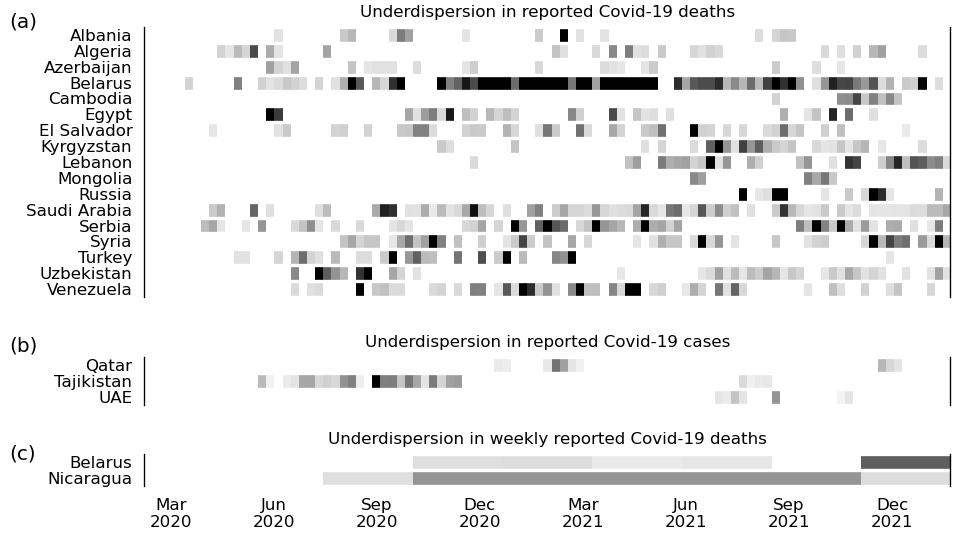

In [20]:
countries_deaths = [renames[c] if c in renames else c for c in countries[deaths_countries_flagged]]
countries_cases  = [renames[c] if c in renames else c for c in countries[cases_countries_flagged]]
countries_deaths_weekly = [renames[c] if c in renames else c for c in countries[deaths_countries_flagged_weekly]]

fig = plt.figure(figsize=(8, 4.5))
plt.set_cmap('Greys')

ax = plt.axes([.15, .45, .84, .5])
plt.title('Underdispersion in reported Covid-19 deaths', fontsize=10)

deaths_ratios_masked = deaths_ratios.copy()
deaths_ratios_masked[deaths_tests==0] = 0

plt.imshow(deaths_ratios_masked[deaths_countries_flagged], aspect='auto', vmin=0, vmax=20)
plt.yticks(np.arange(len(countries_deaths)), countries_deaths)
plt.xticks([])#np.arange(3.5,95,12), ['Mar\n2020', 'Jun\n2020', 'Sep\n2020', 'Dec\n2020', 
#                                   'Mar\n2021', 'Jun\n2021', 'Sep\n2021', 'Dec\n2021'])
plt.tick_params(left=False, bottom=False)

for i in range(-1, len(countries_deaths)):
    plt.plot([0, nweeks], [i+.5,i+.5], 'w', linewidth=2)
    
plt.xlim([.5, nweeks-.5])

#####################
ax = plt.axes([.15, .1, .84, .5/len(countries_deaths)*len(countries_deaths_weekly)])

deaths_ratios_masked_weekly = deaths_ratios_weekly.copy()
deaths_ratios_masked_weekly[deaths_tests_weekly==0] = 0

plt.imshow(deaths_ratios_masked_weekly[deaths_countries_flagged_weekly], aspect='auto', vmin=0, vmax=20)
plt.yticks(np.arange(len(countries_deaths_weekly)), countries_deaths_weekly)
plt.xticks([])
plt.tick_params(left=False, bottom=False)

for i in range(-1, len(countries_deaths_weekly)):
    plt.plot([0, nweeks/10], [i+.5,i+.5], 'w', linewidth=2)
    
plt.xlim([.5, nweeks/10-.5])

# plt.text(.6, .8, '(weekly)')

plt.title('Underdispersion in weekly reported Covid-19 deaths', fontsize=10)

plt.xticks(np.arange(.8, 9.8, 1.15), ['Mar\n2020', 'Jun\n2020', 'Sep\n2020', 'Dec\n2020', 
                                  'Mar\n2021', 'Jun\n2021', 'Sep\n2021', 'Dec\n2021'])
plt.tick_params(left=False, bottom=False)
    
######################
ax = plt.axes([.15, .25, .84, .5/len(countries_deaths)*len(countries_cases)])

cases_ratios_masked = cases_ratios.copy()
cases_ratios_masked[cases_tests==0] = 0

plt.title('Underdispersion in reported Covid-19 cases', fontsize=10)
plt.imshow(cases_ratios_masked[cases_countries_flagged], aspect='auto')
plt.yticks(np.arange(len(countries_cases)), countries_cases)

for i in range(-1, len(countries_cases)):
    plt.plot([0, nweeks], [i+.5,i+.5], 'w', linewidth=2)
    
plt.xticks([])
plt.tick_params(left=False, bottom=False)
    
plt.xlim([.5, nweeks-.5])
    
sns.despine(bottom=True, right=False)

fig.text(.01, .95, '(a)', fontsize=12)
fig.text(.01, .35, '(b)', fontsize=12)
fig.text(.01, .15, '(c)', fontsize=12)

plt.savefig('img/testing.png', dpi=200)
plt.savefig('img/testing.pdf')

In [21]:
# Export the figure data

pd.DataFrame(deaths_ratios_masked[deaths_countries_flagged], 
             index=countries_deaths).to_csv('testing-figure-export.csv', float_format='%.1f')

In [22]:
def showline(country, d, spacing=[0,0]):
    name = renames[country] if country in renames else country
    print(f'{name:15}', end='')
    
    spaceL = ' ' * spacing[0]
    spaceR = ' ' * spacing[1]
    for i in range(d.size):
        if d[i]==1:
            print(spaceL + '*' + spaceR, end='')
        else:
            print(spaceL + '.' + spaceR, end='')
    print('')        

print('Testing reported Covid-19 cases and deaths for underdispersion compared to Poisson, based on the WHO data. Each')
print(f'dot is one week, {nweeks} weeks in total. Asterisks denote p<0.05. Only countries with at least 15 weeks with p<0.05 ')
print('undispersion, or at least 4 weeks in a row, are shown. Summed weekly counts are separately tested for under-')
print('dispersion in chunks of 10 weeks; countries with at least 5 significant weeks are shown.')
print('')
print('')

print('  == REPORTED DEATHS ==')
for country_num, country in enumerate(countries):
    if deaths_countries_flagged[country_num]:
        showline(country, deaths_tests[country_num])
print('')

print('  == REPORTED CASES ==')
for country_num, country in enumerate(countries):
    if cases_countries_flagged[country_num]:
        showline(country, cases_tests[country_num])
print('')

print('  == REPORTED DEATHS PER WEEK ==')
for country_num, country in enumerate(countries):
    if deaths_countries_flagged_weekly[country_num]:
        showline(country, deaths_tests_weekly[country_num], (4,5))
print('')

# print('== CASES WEEKLY ==')
# for country_num, country in enumerate(countries):
#     if cases_countries_flagged_weekly[country_num]:
#         showline(country, cases_tests[country_num], 3)
# print('')

print('     | Jan Feb Mar Apr  May Jun  Jul Aug  Sep Oct Nov Dec | Jan Feb Mar Apr  May Jun Jul Aug  Sep Oct Nov Dec | Jan')
print('     |                        2020                        |                        2021                       |    ')

Testing reported Covid-19 cases and deaths for underdispersion compared to Poisson, based on the WHO data. Each
dot is one week, 100 weeks in total. Asterisks denote p<0.05. Only countries with at least 15 weeks with p<0.05 
undispersion, or at least 4 weeks in a row, are shown. Summed weekly counts are separately tested for under-
dispersion in chunks of 10 weeks; countries with at least 5 significant weeks are shown.


  == REPORTED DEATHS ==
Albania        .................*.......**....***......*........*..*.*..*..................*.***...................
Algeria        ..........*****.**.....*...........................**...*.*.***.*...****............*.*.*.**....*...
Azerbaijan     ................****......*.****..*.....**.......*.......***..**..............*....*..*.............
Belarus        ......*.....*..******.*.****.****....***************************..****************.**********.***.*.
Cambodia       ........................................................................

## Mean / variance ratios

<IPython.core.display.Javascript object>


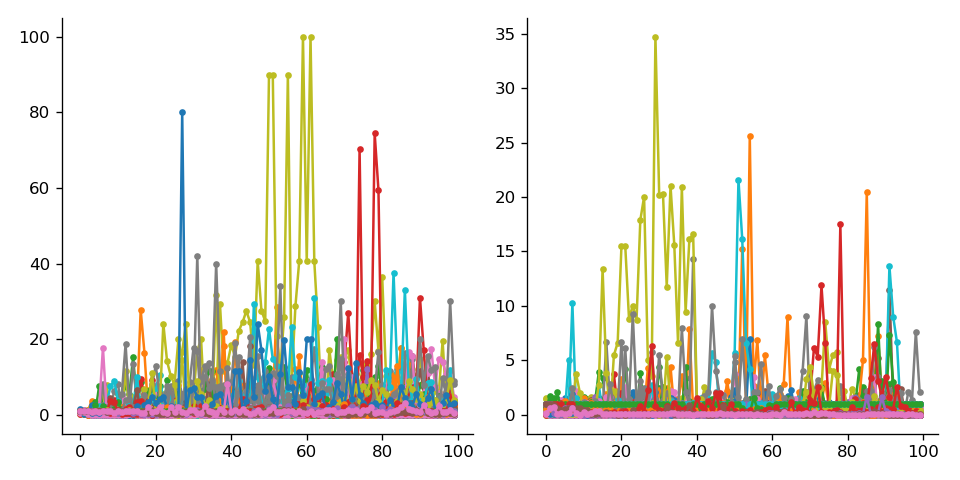

In [23]:
plt.figure(figsize=(8,4))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

for i,country in enumerate(countries):
    plt.sca(ax1)
    plt.plot(deaths_ratios[i], '.-')

    plt.sca(ax2)
    plt.plot(cases_ratios[i], '.-')
    
# plt.sca(ax1)
# plt.plot(deaths_ratios[countries=='Iran (Islamic Republic of)'].ravel(), 'k.-')

sns.despine()
plt.tight_layout()

<IPython.core.display.Javascript object>


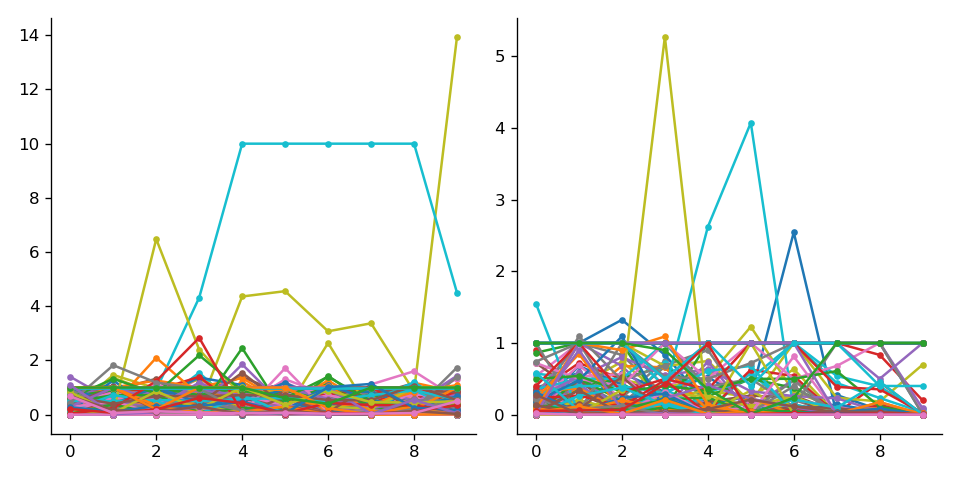

In [24]:
plt.figure(figsize=(8,4))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

for i,country in enumerate(countries):
    plt.sca(ax1)
    plt.plot(deaths_ratios_weekly[i], '.-')

    plt.sca(ax2)
    plt.plot(cases_ratios_weekly[i], '.-')
    
sns.despine()
plt.tight_layout()

In [25]:
for x in [np.mean(deaths_ratios, axis=1),
          np.max(deaths_ratios, axis=1),
          np.mean(cases_ratios, axis=1),
          np.max(cases_ratios, axis=1),
          np.mean(deaths_ratios_weekly, axis=1),
          np.max(deaths_ratios_weekly, axis=1),
          np.mean(cases_ratios_weekly, axis=1),
          np.max(cases_ratios_weekly, axis=1)]:

    ind = np.argsort(x)[::-1][:5]
    for i in ind:
        name = renames[countries[i]] if countries[i] in renames else countries[i]
        print(f'{name:15} {x[i]:.2f}')
    print('')

Belarus         15.82
Serbia          5.94
Saudi Arabia    5.46
Venezuela       5.35
Syria           5.00

Belarus         100.00
Venezuela       80.00
Russia          74.47
Turkey          42.06
Syria           40.00

Tajikistan      4.14
Syria           1.68
Egypt           1.66
Qatar           1.29
Tuvalu          1.00

Tajikistan      34.71
Egypt           25.61
Qatar           21.58
UAE             17.48
Syria           14.28

Nicaragua       6.13
Belarus         3.29
Tajikistan      1.33
Saint Helena    1.00
Tuvalu          1.00

Belarus         13.94
Nicaragua       10.00
Tajikistan      6.48
UAE             2.84
Senegal         2.64

Tuvalu          1.00
Niue            1.00
Cook Islands    1.00
Saint Helena    1.00
Micronesia (Federated States of) 1.00

Tajikistan      5.27
Nicaragua       4.07
Brunei Darussalam 2.54
Cayman Islands  1.23
New Caledonia   1.09



In [26]:
maxmeanratio = np.amax(np.concatenate((
    np.mean(deaths_ratios, axis=1, keepdims=True),
    np.mean(cases_ratios, axis=1, keepdims=True),
    np.mean(deaths_ratios_weekly, axis=1, keepdims=True),
    np.mean(cases_ratios_weekly, axis=1, keepdims=True)),
        axis=1), axis=1)

In [27]:
ind = np.argsort(maxmeanratio)[::-1]

for i in ind:
    if maxmeanratio[i] > 2.5:
        name = renames[countries[i]] if countries[i] in renames else countries[i]
        print(f'{name:15} {maxmeanratio[i]:.1f}')

Belarus         15.8
Nicaragua       6.1
Serbia          5.9
Saudi Arabia    5.5
Venezuela       5.3
Syria           5.0
Tajikistan      4.1
El Salvador     3.7
Egypt           3.6
Turkey          3.5
Uzbekistan      3.5
Lebanon         3.4
Russia          3.3
Kyrgyzstan      3.0
Algeria         2.7


In [28]:
# Export as clean CSV

df_ratios = pd.DataFrame(
    np.concatenate(
        (
            np.mean(deaths_ratios, axis=1, keepdims=True),
            np.mean(cases_ratios, axis=1, keepdims=True),
            np.mean(deaths_ratios_weekly, axis=1, keepdims=True),
            np.mean(cases_ratios_weekly, axis=1, keepdims=True),
            maxmeanratio[:, np.newaxis]
        ),
        axis=1),
    index=countries,
    columns=['Underdispersion ratio (cases, daily, mean over weeks)',
             'Underdispersion ratio (deaths, daily, mean over weeks)',
             'Underdispersion ratio (cases, weekly, mean over 7-week blocks)',
             'Underdispersion ratio (deaths, weekly, mean over 7-week blocks)',
             'Underdispersion ratio (max)'])

df_ratios.to_csv('underdispersion-ratios.csv', float_format='%.2f')

## Relationship to the undercount based on excess mortality

In [29]:
# ex = pd.read_csv('https://raw.githubusercontent.com/dkobak/excess-mortality/main/excess-mortality.csv')
ex = pd.read_csv('frozen-data/excess-mortality.csv')

con = ex['Country'].values
und = ex['Undercount ratio'].values

wmd2who = {'Moldova':'Republic of Moldova',
           'Russia': 'Russian Federation',
           'Bosnia': 'Bosnia and Herzegovina',
           'Bolivia': 'Bolivia (Plurinational State of)',
           'United States': 'United States of America',
           'United Kingdom': 'The United Kingdom',
           'Kosovo': 'Kosovo[1]',
           'Iran': 'Iran (Islamic Republic of)',
           'South Korea': 'Republic of Korea',
           'Brunei': 'Brunei Darussalam',
           'Palestine': 'occupied Palestinian territory, including east Jerusalem'}

con = np.array([c if c not in wmd2who else wmd2who[c] for c in con])
print('Not found in the WHO dataset: ', con[~np.isin(con, countries)])

undercounts = np.zeros(countries.size) * np.nan
for i,c in enumerate(countries):
    if c in con:
        undercounts[i] = und[con==c]
        if np.isnan(und[con==c]):
            undercounts[i] = 1
        
print(np.sum(~np.isnan(undercounts)))

Not found in the WHO dataset:  ['Hong Kong' 'Macao' 'Taiwan' 'Transnistria']
113


In [30]:
signif = (
    deaths_countries_flagged 
    | cases_countries_flagged 
    | deaths_countries_flagged_weekly
    | cases_countries_flagged_weekly
)

<IPython.core.display.Javascript object>


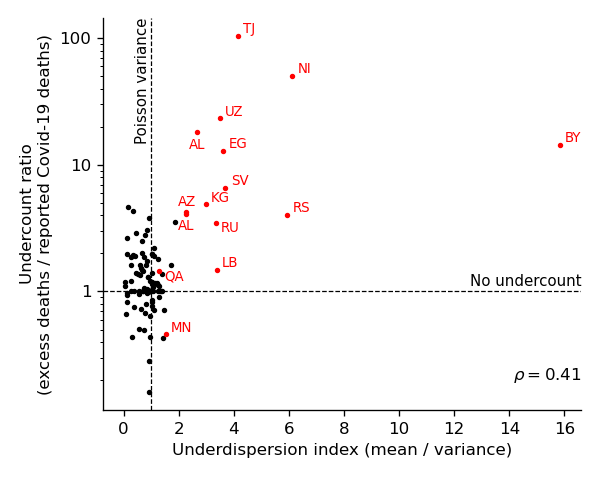

In [37]:
plt.figure(figsize=(5,4))
plt.scatter(maxmeanratio[~signif], undercounts[~signif], c='k', s=5)
plt.scatter(maxmeanratio[signif], undercounts[signif], c='r', s=5)
plt.yscale('log')

plt.xlabel('Underdispersion index (mean / variance)')
plt.ylabel('Undercount ratio\n(excess deaths / reported Covid-19 deaths)')

shorten = {'Belarus': 'BY',
           'Nicaragua': 'NI',
           'Tajikistan': 'TJ',
           'Uzbekistan': 'UZ',
           'Egypt': 'EG',
           'El Salvador': 'SV',
           'Russian Federation': 'RU',
           'Lebanon': 'LB',
           'Republic of Moldova': 'MD',
           'Azerbaijan': 'AZ',
           'Kyrgyzstan': 'KG',
           'Serbia': 'RS',
           'Albania': 'AL',
           'Kazakhstan': 'KZ',
           'Monaco': 'MC',
           'Kuwait': 'KW',
           'Mongolia': 'MN',
           'Qatar': 'QA',
           'Algeria': 'AL',
          }

deltas = {'RU': [0, .8], 'AZ': [-.5, 1.05], 'AL': [-.5, .7], 'QA': [0,.8]}

ind = (maxmeanratio > 2.5) & ~np.isnan(undercounts) & signif
ind = ~np.isnan(undercounts) & signif
for i in np.where(ind)[0]:
    if shorten[countries[i]] in deltas:
        d = deltas[shorten[countries[i]]]
    else:
        d = [0, 1]
    
    plt.text(maxmeanratio[i]+.2 + d[0], undercounts[i] * 1.05 * d[1],
             shorten[countries[i]], fontsize=8, color='r')
    
sns.despine()
plt.tight_layout()

plt.yticks([1,10,100],['1','10','100'])

xl = plt.xlim()
yl = plt.ylim()
plt.plot(xl, [1, 1], 'k--', lw=.75, zorder=-1)
plt.plot([1, 1], yl, 'k--', lw=.75, zorder=-1)
plt.xlim(xl)
plt.ylim(yl)
plt.text(xl[1], 1.1, 'No undercount', fontsize=9, ha='right')
plt.text(0.4, yl[1], 'Poisson variance', fontsize=9, va='top', rotation=90)

rho = np.corrcoef(maxmeanratio[~np.isnan(undercounts)], undercounts[~np.isnan(undercounts)])[0,1]
plt.text(xl[1], .2, fr'$\rho={rho:.2f}$', fontsize=10, ha='right')

plt.savefig('img/correlation.png', dpi=200)
plt.savefig('img/correlation.pdf', dpi=200)

## Russian regions

In [32]:
# https://docs.google.com/spreadsheets/d/1nCxvNcuZGNswsf97mliLikmUIsOrOGZtL-VI7xfN-Zw

# df = pd.read_csv('https://docs.google.com/spreadsheets/d/1nCxvNcuZGNswsf97mliLikmUIsOrOGZtL-VI7xfN-Zw/export?format=csv&gid=375550280')
df = pd.read_csv('frozen-data/StopCoronaRF - died.csv')

count = 0
print('== DEATHS ==')
for row in range(df.shape[0]):
    t = df.values[row,1:]
    t = np.diff(t[::-1])
    t[t<0] = 0
    
    a = np.where(df.columns[1:][::-1] == '30.03.2020')[0][0]
    b = np.where(df.columns[1:][::-1] == enddate[8:]+'.'+enddate[5:7]+'.'+enddate[:4])[0][0]
    ind = np.arange(a-1, b+1-1)
    t = t[ind]
    t = np.concatenate((np.zeros(28), t)) # append four weeks of zeros
    
    d,r = chop_and_test(t, window=7, nrep=1000)
    
    if criterion(d, cutoff=15, chunkcutoff=4):
        count += 1
        print(f'{df.values[row,0][:15]:15}', end='')
        for i in range(d.size):
            if d[i]==1:
                print('*', end='')
            else:
                print('.', end='')
        print('')
        
print(f'{count}/{df.shape[0]} regions')

== DEATHS ==
Алтайский край .........................................*..*.*.*.**............*.....*.**..****..*...**************
Астраханская об.....................*.*............*****..**.*.*****.**************.**.***********.****.***********
Белгородская об..........................................*.**.*....*.**********......*.*.*.**...***.***..***.******
Брянская област.....................................................................*....***.****.****.**.**.**.***
Владимирская об...............*.......*......*...............******.**....................................*.......*
Волгоградская о..........................***........*****.***.****.********.**.********.*********.*.*********.****.
Вологодская обл.................................................***..****************.*.********.***.*...*.....*...
Воронежская обл......................................................*..........*.........................****.....
Забайкальский к.................................**.........

In [33]:
# df = pd.read_csv('https://docs.google.com/spreadsheets/d/1nCxvNcuZGNswsf97mliLikmUIsOrOGZtL-VI7xfN-Zw/export?format=csv&gid=1771324359')
df = pd.read_csv('frozen-data/StopCoronaRF - infected.csv')

count = 0
which = np.zeros(df.shape[0]).astype(bool)

print('== CASES ==')
for row in range(df.shape[0]):
    t = df.values[row,1:]
    t = np.diff(t[::-1])
    
    a = np.where(df.columns[1:][::-1] == '30.03.2020')[0][0]
    b = np.where(df.columns[1:][::-1] == enddate[8:]+'.'+enddate[5:7]+'.'+enddate[:4])[0][0]
    ind = np.arange(a-1, b+1-1)
    t = t[ind]
    t = np.concatenate((np.zeros(28), t)) # append four weeks of zeros
    
    d,r = chop_and_test(t, window=7, nrep=1000)
    
    if criterion(d, cutoff=15, chunkcutoff=4):
        count += 1
        which[row] = True
        
        print(f'{df.values[row,0][:15]:15}', end='')
        for i in range(d.size):
            if d[i]==1:
                print('*', end='')
            else:
                print('.', end='')
        print('')
        
print('')
print(f'{count}/{df.shape[0]} regions')
print(f'Passed: {df.values[:,0][~which]}')

== CASES ==
Алтайский край ..............***......*.*****..*.*********************************....************.....*******.....
Амурская област...................**.**..**.*.....************.*..*.************......***************..*******..***
Архангельская о................*.*.................*******.*.***...*.*********.**...*.****.*******.*..****.*.*.....
Астраханская об....................*..*..........******.****************.*.*.***........*******..*..***********....
Белгородская об............*****...**.*****..*..*..**************..***************.**..*********.*...********......
Брянская област...........****.*...........*......***...********..*********.******..****.**.****......**...****.*..
Владимирская об.............*.*****.********..*.***.***.***********..*************....**********....*********......
Волгоградская о...............*******.*..***...********.********.*..***************....**************.*****........
Вологодская обл.......*........**.****.******...**.*...***.*

Тульская област...........***.****..***********...***..*********.********.********..**************....**********...
Тюменская облас..................*.***.****.*..*.****************.***********..***....*************.***********....
Удмуртская Респ...............***.*...**......*..**********.**..*******************...***.*******...*****..*...*...
Ульяновская обл.............*..*******..**.**.****************.*.*.*****************...*************..****..**.*...
Хабаровский кра............**.*....*.......*......*...*****.***.....**.*...**.........**************...*.*.***.....
Ханты-Мансийски.................*.........*..*.************..*...*.*****.*****....*...***.******.***.*********.....
Челябинская обл...................**..**..**..**..*.*..**********...***************...***************..******......
Чеченская Респу.........****.*........**.*.*.***.......***.......****************......***.*...*****.*****.***.....
Чукотский автон.........................................................

## US states

There are currently 60 public health jurisdictions reporting cases of COVID-19. This includes the 50 states, the District of Columbia, New York City, the U.S. territories of American Samoa, Guam, the Commonwealth of the Northern Mariana Islands, Puerto Rico, and the U.S Virgin Islands as well as three independent countries in compacts of free association with the United States, Federated States of Micronesia, Republic of the Marshall Islands, and Republic of Palau. New York State’s reported case and death counts do not include New York City’s counts as they separately report nationally notifiable conditions to CDC.

In [34]:
# df = pd.read_csv('https://data.cdc.gov/api/views/9mfq-cb36/rows.csv')

df = pd.read_csv('frozen-data/United_States_COVID-19_Cases_and_Deaths_by_State_over_Time.csv')

print(np.unique(df['state']).size)

60


In [35]:
print('== DEATHS ==')
for state in np.unique(df['state']):
    print('.', end='')
    dates = df[df['state']==state]['submission_date'].values
    dates = np.array([d[6:]+'-'+d[:2]+'-'+d[3:5] for d in dates])
    ind = np.argsort(dates)
    dates = dates[ind]
    t = df[df['state']==state]['new_death'].values
    t = t[ind]
    
    ind = [(s>='2020-03-02') & (s<=enddate) for s in dates]
    t = t[ind]
   
    d,r = chop_and_test(t, window=7, nrep=1000)
    
    if criterion(d, cutoff=15, chunkcutoff=4):
        count += 1
        print(f'{state[:20]:20}', end='')
        for i in range(d.size):
            if d[i]==1:
                print('*', end='')
            else:
                print('.', end='')
        print('')


== DEATHS ==
............................................................

In [36]:
print('== CASES ==')
for state in np.unique(df['state']):
    print('.', end='')
    dates = df[df['state']==state]['submission_date'].values
    dates = np.array([d[6:]+'-'+d[:2]+'-'+d[3:5] for d in dates])
    ind = np.argsort(dates)
    dates = dates[ind]
    t = df[df['state']==state]['new_case'].values
    t = t[ind]
    
    ind = [(s>='2020-03-02') & (s<=enddate) for s in dates]
    t = t[ind]
   
    d,r = chop_and_test(t, window=7, nrep=1000)
    
    if criterion(d, cutoff=15, chunkcutoff=4):
        count += 1
        print(f'{state[:20]:20}', end='')
        for i in range(d.size):
            if d[i]==1:
                print('*', end='')
            else:
                print('.', end='')
        print('')

== CASES ==
............................................................